# Fina Data Dev Book

## Initialization

### Imports

In [1]:
from os import getcwd, pardir
from os.path import normpath
from os.path import join as path_join
from typing import Optional
from typing import Union
import time
import datetime as dt
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import ticker
from emon_tools.emon_fina.fina_utils import Utils as Ut
from emon_tools.emon_fina.fina_plot import PlotData
from emon_tools.emon_fina.fina_plot import FinaPlot
from emon_tools.emon_fina.fina_time_series import FinaDataFrame
from emon_tools.emon_fina.fina_models import FinaByTimeParamsModel
from emon_tools.emon_fina.fina_models import OutputAverageEnum
from emon_tools.emon_fina.fina_models import TimeRefEnum
from emon_tools.emon_fina.fina_models import OutputType
from emon_tools.emon_fina.fina_services import FinaMeta



### Helpers methods

In [2]:
def get_utc_datetime_from_timestamp(
    timestamp
):
    """Get diff between two timestamps"""
    return dt.datetime.fromtimestamp(timestamp, tz=dt.timezone.utc)

def get_diff_time(
    time_start,
    time_end
):
    """Get diff between two timestamps"""
    start = get_utc_datetime_from_timestamp(time_start)
    end = get_utc_datetime_from_timestamp(time_end)
    if start <= end:
        return end - start
    return start - end

def print_sep():
    """Get separator"""
    sep = '-' * 15
    print(sep)

def print_info_head(
    file_name: str,
    start_perf: float,
    fr: FinaDataFrame
):
    """Print info from data"""
    print_sep()
    print("Get data from phpFina File")
    print(f"Feed Id: {file_name}")
    print(f"Data retrieved in {time.perf_counter() - start_perf}s")
    print(f"Meta {fr.meta}s")
    print_sep()

def print_info(
    file_name: str,
    start_perf: float,
    fina: FinaDataFrame,
    df: pd.DataFrame,
):
    """Print info from data"""
    sep = '-' * 15
    print(sep)
    print("Get data from phpFina File")
    print(f"Feed Id: {file_name}")
    print(f"Data retrieved in {time.perf_counter() - start_perf}s")
    print(sep)
    print("META: ")
    print(sep)
    print(
        f"File UTC start at {get_utc_datetime_from_timestamp(fina.meta.start_time)}"
    )
    print(
        f"File UTC end at {get_utc_datetime_from_timestamp(fina.meta.end_time)}"
    )
    print(f"Nb days: {fina.meta.calculate_nb_days()}")
    print(f"meta: {fina.meta}")
    print(sep)
    print("SEARCH: ")
    print(sep)
    print(
        f"Search UTC start at {get_utc_datetime_from_timestamp(
            fina.reader.props.search.start_time)} "
    )
    print(
        f"Search UTC end at {get_utc_datetime_from_timestamp(
            fina.reader.props.search.start_time + fina.reader.props.search.time_window)}"
    )
    print(f"search: {fina.reader.props.search}")
    print(sep)
    print("COMPUTED: ")
    print(sep)
    print(f"start_search: {get_utc_datetime_from_timestamp(
        fina.meta.start_time + fina.reader.props.start_search)}")
    print(f"diff_search: {get_diff_time(
        fina.reader.props.search.start_time,
        fina.meta.start_time + fina.reader.props.start_search)}")
    print(
        f"window_max: {fina.reader.props.window_max} points"
        f"({fina.reader.props.window_max * fina.reader.props.search.time_interval}s - "
        f"{(fina.reader.props.window_max * fina.reader.props.search.time_interval)/60}min)"
    )
    print(
        f"window_search: {fina.reader.props.window_search} points"
        f"({fina.reader.props.window_search * fina.reader.props.search.time_interval}s - "
        f"{(fina.reader.props.window_search * fina.reader.props.search.time_interval)/60}min)"
    )
    print(sep)
    print("Result: ")
    print(sep)
    print(f"Shape: {df.shape[0]}.")
    print(f"Window: {df.index[-1] - df.index[0]}.")

def get_start_search_time(fr: FinaDataFrame):
    """Get start limits"""
    return fr.meta.start_time + (fr.reader.props.start_search * fr.meta.interval)

def has_values(data: pd.DataFrame):
    """Get start limits"""
    nb_nans = data[np.isnan(data['values'])].shape[0]
    nb_rows = data.shape[0]
    return nb_nans < nb_rows

def get_start_limits(fr: FinaDataFrame):
    """Get start limits"""
    meta_start = dt.datetime.fromtimestamp(
        fr.meta.start_time,
        tz=dt.timezone.utc
    )
    start_search_time = get_start_search_time(fr)
    user_start = dt.datetime.fromtimestamp(
        start_search_time,
        tz=dt.timezone.utc
    )
    start_search = dt.datetime.fromtimestamp(
        fr.reader.props.search.start_time,
        tz=dt.timezone.utc
    )
    return meta_start, start_search, user_start

def get_end_limits(fr: FinaDataFrame):
    """Get start limits"""
    start_search_time = get_start_search_time(fr)
    user_end = dt.datetime.fromtimestamp(
        start_search_time + (fr.reader.props.window_max * fr.meta.interval),
        tz=dt.timezone.utc
    )
    end_search = dt.datetime.fromtimestamp(
        fr.reader.props.search.start_time + fr.reader.props.search.time_window,
        tz=dt.timezone.utc
    )
    return end_search, user_end

def get_min_max_values(data: pd.DataFrame):
    """Get start limits"""
    if not has_values(data):
        return 0, 0
    min_value = (np.nanmin(data['values'])) #math.floor
    max_value = (np.nanmax(data['values'])) # math.ceil
    return min_value, max_value

def get_min_max_dates(data: pd.DataFrame):
    """Get start limits"""
    return data.index[0], data.index[-1]

def plot_values_with_limits(data: pd.DataFrame, fr: FinaDataFrame):
    """Plot values with limits"""
    meta_start, start_search, user_start = get_start_limits(fr)
    end_search, user_end = get_end_limits(fr)
    min_value, max_value = get_min_max_values(data=data)
    big_line = '8'
    regular_line = '6'
    small_line = '3'
    plt.plot(
        [meta_start, meta_start],
        [min_value, max_value],
        label="Meta Start time", marker = 'o', color = 'r', linewidth = big_line
    )
    plt.plot(
        [start_search, start_search],
        [min_value, max_value],
        label="Search Start time", marker = 'o', color = 'b', linewidth = regular_line
    )
    plt.plot(
        [end_search, end_search],
        [min_value, max_value],
        label="Search End time", marker = 'o', color = 'b', linewidth = regular_line
    )
    plt.plot(
        [user_start, user_start],
        [min_value, max_value],
        label="Computed Start time", marker = 'o', color = '#880088', linewidth = regular_line
    )
    plt.plot(
        [user_end, user_end],
        [min_value, max_value],
        label="Computed End time", marker = 'o', color = '#880088', linewidth = regular_line
    )
    plt.plot(
        [data.index[0], data.index[0]],
        [min_value, max_value],
        label="First value time", marker = 'o', color = 'g', linewidth = small_line
    )
    plt.plot(
        [data.index[-1], data.index[-1]],
        [min_value, max_value],
        label="End value time", marker = 'o', color = 'g', linewidth = small_line
    )
    plt.plot(data.index, data['values'], label="Fina Values")
    plt.title("Fina Values")
    plt.xlabel("Time")
    plt.ylabel("Values")
    FinaPlot.auto_plot_grid(x_grid=False, y_grid=False)
    plt.legend()

def plot_start_values_with_limits(data: pd.DataFrame, fr: FinaDataFrame):
    """Plot values with limits"""
    meta_start, start_search, user_start = get_start_limits(fr)
    min_value, max_value = get_min_max_values(data=data)
    big_line = '8'
    regular_line = '6'
    small_line = '3'
    plt.plot(
        [meta_start, meta_start],
        [min_value, max_value],
        label="Meta Start time", marker = 'o', color = 'r', linewidth = big_line
    )
    plt.plot(
        [start_search, start_search],
        [min_value, max_value],
        label="Computed Start time", marker = 'o', color = 'b', linewidth = big_line
    )
    plt.plot(
        [user_start, user_start],
        [min_value, max_value],
        label="User Start time", marker = 'o', color = '#880088', linewidth = big_line
    )
    plt.plot(
        [data.index[0], data.index[0]],
        [min_value, max_value],
        label="First value time", marker = 'o', color = 'g', linewidth = small_line
    )
    plt.plot(data.index[0:2], data['values'][0:2], label="Fina Values")
    plt.title("Start search")
    plt.xlabel("Time")
    plt.ylabel("Values")
    FinaPlot.auto_plot_grid(x_grid=False, x_minor=False)
    plt.legend()

def plot_debug(data: pd.DataFrame, fr: FinaDataFrame):
    """plot for debug"""
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 1, 1)
    plot_values_with_limits(data, fr)
    plt.subplot(2, 1, 2)
    plot_start_values_with_limits(data, fr)
    plt.show()

def plot_compare(datas_1: dict, datas_2: dict, datas_3: dict):
    """plot for debug"""
    plt.figure(figsize=(18, 18))
    plt.subplot(3, 1, 1)
    plot_values_with_limits(**datas_1)
    plt.subplot(3, 1, 2)
    plot_values_with_limits(**datas_2)
    plt.subplot(3, 1, 3)
    plot_values_with_limits(**datas_3)
    plt.show()

def initFinaData(
    file_name: str
):
    """Print compare info"""
    DATA_DIR = normpath(
        path_join(getcwd(), pardir, "datas")
    )
    return FinaDataFrame(
        file_name=str(file_name),
        data_dir=DATA_DIR
    )

def print_info_compare_starts(
    data_1: dict,
    data_2: dict,
    data_3: dict,
):
    """Print starts comparaison"""
    has_data_1 = has_values(data_1.get('data'))
    has_data_2 = has_values(data_2.get('data'))
    has_data_3 = has_values(data_3.get('data'))
    if has_data_1:
        meta_start_1, start_search_1, user_start_1 = get_start_limits(data_1.get('fr'))
        end_search_1, user_end_1 = get_end_limits(data_1.get('fr'))
        min_value_1, max_value_1 = get_min_max_dates(data_1.get('data'))
    
    if has_data_2:
        meta_start_2, start_search_2, user_start_2 = get_start_limits(data_2.get('fr'))
        end_search_2, user_end_2 = get_end_limits(data_2.get('fr'))
        min_value_2, max_value_2 = get_min_max_dates(data_2.get('data'))
    
    if has_data_3:
        meta_start_3, start_search_3, user_start_3 = get_start_limits(data_1.get('fr'))
        end_search_3, user_end_3 = get_end_limits(data_3.get('fr'))
        min_value_3, max_value_3 = get_min_max_dates(data_3.get('data'))

    print_sep()
    print("Meta: ")
    if has_data_1:
        print(f"Meta Start COMPLETE: {meta_start_1}")
    if has_data_2:
        print(f"Meta Start PARTIAL:  {meta_start_2}")
    if has_data_3:
        print(f"Meta Start AS_IS:    {meta_start_3}")
    print_sep()
    print("Search: ")
    if has_data_1:
        print(f"Search COMPLETE - Start at {start_search_1} -- End at {end_search_1} -- ({end_search_1 - start_search_1})")
    if has_data_2:
        print(f"Search PARTIAL  - Start at {start_search_2} -- End at {end_search_2} -- ({end_search_2 - start_search_2})")
    if has_data_3:
        print(f"Search AS_IS    - Start at {start_search_3} -- End at {end_search_3} -- ({end_search_3 - start_search_3})")
    print("Computed Search: ")
    if has_data_1:
        print(f"Computed COMPLETE - Start at {user_start_1} -- End at {user_end_1} -- ({user_end_1 - user_start_1})")
    if has_data_2:
        print(f"Computed PARTIAL  - Start at {user_start_2} -- End at {user_end_2} -- ({user_end_2 - user_start_2})")
    if has_data_3:
        print(f"Computed AS_IS    - Start at {user_start_3} -- End at {user_end_3} -- ({user_end_3 - user_start_3})")
    print("Retrieved: ")
    if has_data_1:
        print(f"Retrieved COMPLETE - Start at {min_value_1} -- End at {max_value_1} -- ({max_value_1 - min_value_1})")
    if has_data_2:
        print(f"Retrieved PARTIAL  - Start at {min_value_2} -- End at {max_value_2} -- ({max_value_2 - min_value_2})")
    if has_data_3:
        print(f"Retrieved AS_IS    - Start at {min_value_3} -- End at {max_value_3} -- ({max_value_3 - min_value_3})")

def print_info_compare(
    file_name: str,
    start_perf: float,
    data_1: dict,
    data_2: dict,
    data_3: dict,
):
    """Print compare info"""
    print_info_head(file_name, start_perf, data_1.get('fr'))
    print_info_compare_starts(data_1, data_2, data_3)

def write_to_file(
    file_name: str,
    start_perf: float,
    data_1: dict,
    data_2: dict,
    data_3: dict,
):
    """Print compare info"""
    print_info_head(file_name, start_perf)
    print_info_compare_starts(data_1, data_2, data_3)

def compare_reads(
    time_start: int,
    time_window: int,
    time_interval: int,
    output_type: OutputType,
    time_ref_start: TimeRefEnum
):
    """Compare direct values BY_SEARCH"""
    start_perf = time.perf_counter()
    props = FinaByTimeParamsModel(**{
        "start_time": time_start,
        "time_window": time_window,
        "time_interval": time_interval,
        "output_type": output_type,
        "output_average": OutputAverageEnum.COMPLETE,
        "time_ref_start": time_ref_start
    })
    fr = initFinaData("1")
    data_1 = {
        "data": fr.get_df_data(props=props),
        "fr": fr
    }
    props = FinaByTimeParamsModel(**{
        "start_time": time_start,
        "time_window": time_window,
        "time_interval": time_interval,
        "output_type": output_type,
        "output_average": OutputAverageEnum.PARTIAL,
        "time_ref_start": time_ref_start
    })
    fr = initFinaData("1")
    data_2 = {
        "data": fr.get_df_data(props=props),
        "fr": fr
    }
    props = FinaByTimeParamsModel(**{
        "start_time": time_start,
        "time_window": time_window,
        "time_interval": time_interval,
        "output_type": output_type,
        "output_average": OutputAverageEnum.AS_IS,
        "time_ref_start": time_ref_start
    })
    fr = initFinaData("1")
    data_3 = {
        "data": fr.get_df_data(props=props),
        "fr": fr
    }
    print_info_compare(
        file_name="1",
        start_perf=start_perf,
        data_1=data_1,
        data_2=data_2,
        data_3=data_3
    )
    plot_compare(data_1, data_2, data_3)

## Use cases

### Direct Reads

#### Case 1: Direct Read BY_TIME

---------------
Get data from phpFina File
Feed Id: 1
Data retrieved in 0.0072326629888266325s
Meta interval=10 start_time=1575981140 end_time=1621499760 npoints=4551863 size=18207452s
---------------
---------------
Meta: 
Meta Start COMPLETE: 2019-12-10 12:32:20+00:00
Meta Start PARTIAL:  2019-12-10 12:32:20+00:00
Meta Start AS_IS:    2019-12-10 12:32:20+00:00
---------------
Search: 
Search COMPLETE - Start at 2019-12-10 12:17:20+00:00 -- End at 2019-12-10 12:47:20+00:00 -- (0:30:00)
Search PARTIAL  - Start at 2019-12-10 12:17:20+00:00 -- End at 2019-12-10 12:47:20+00:00 -- (0:30:00)
Search AS_IS    - Start at 2019-12-10 12:17:20+00:00 -- End at 2019-12-10 12:47:20+00:00 -- (0:30:00)
Computed Search: 
Computed COMPLETE - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 12:47:20+00:00 -- (0:15:00)
Computed PARTIAL  - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 12:47:20+00:00 -- (0:15:00)
Computed AS_IS    - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 12

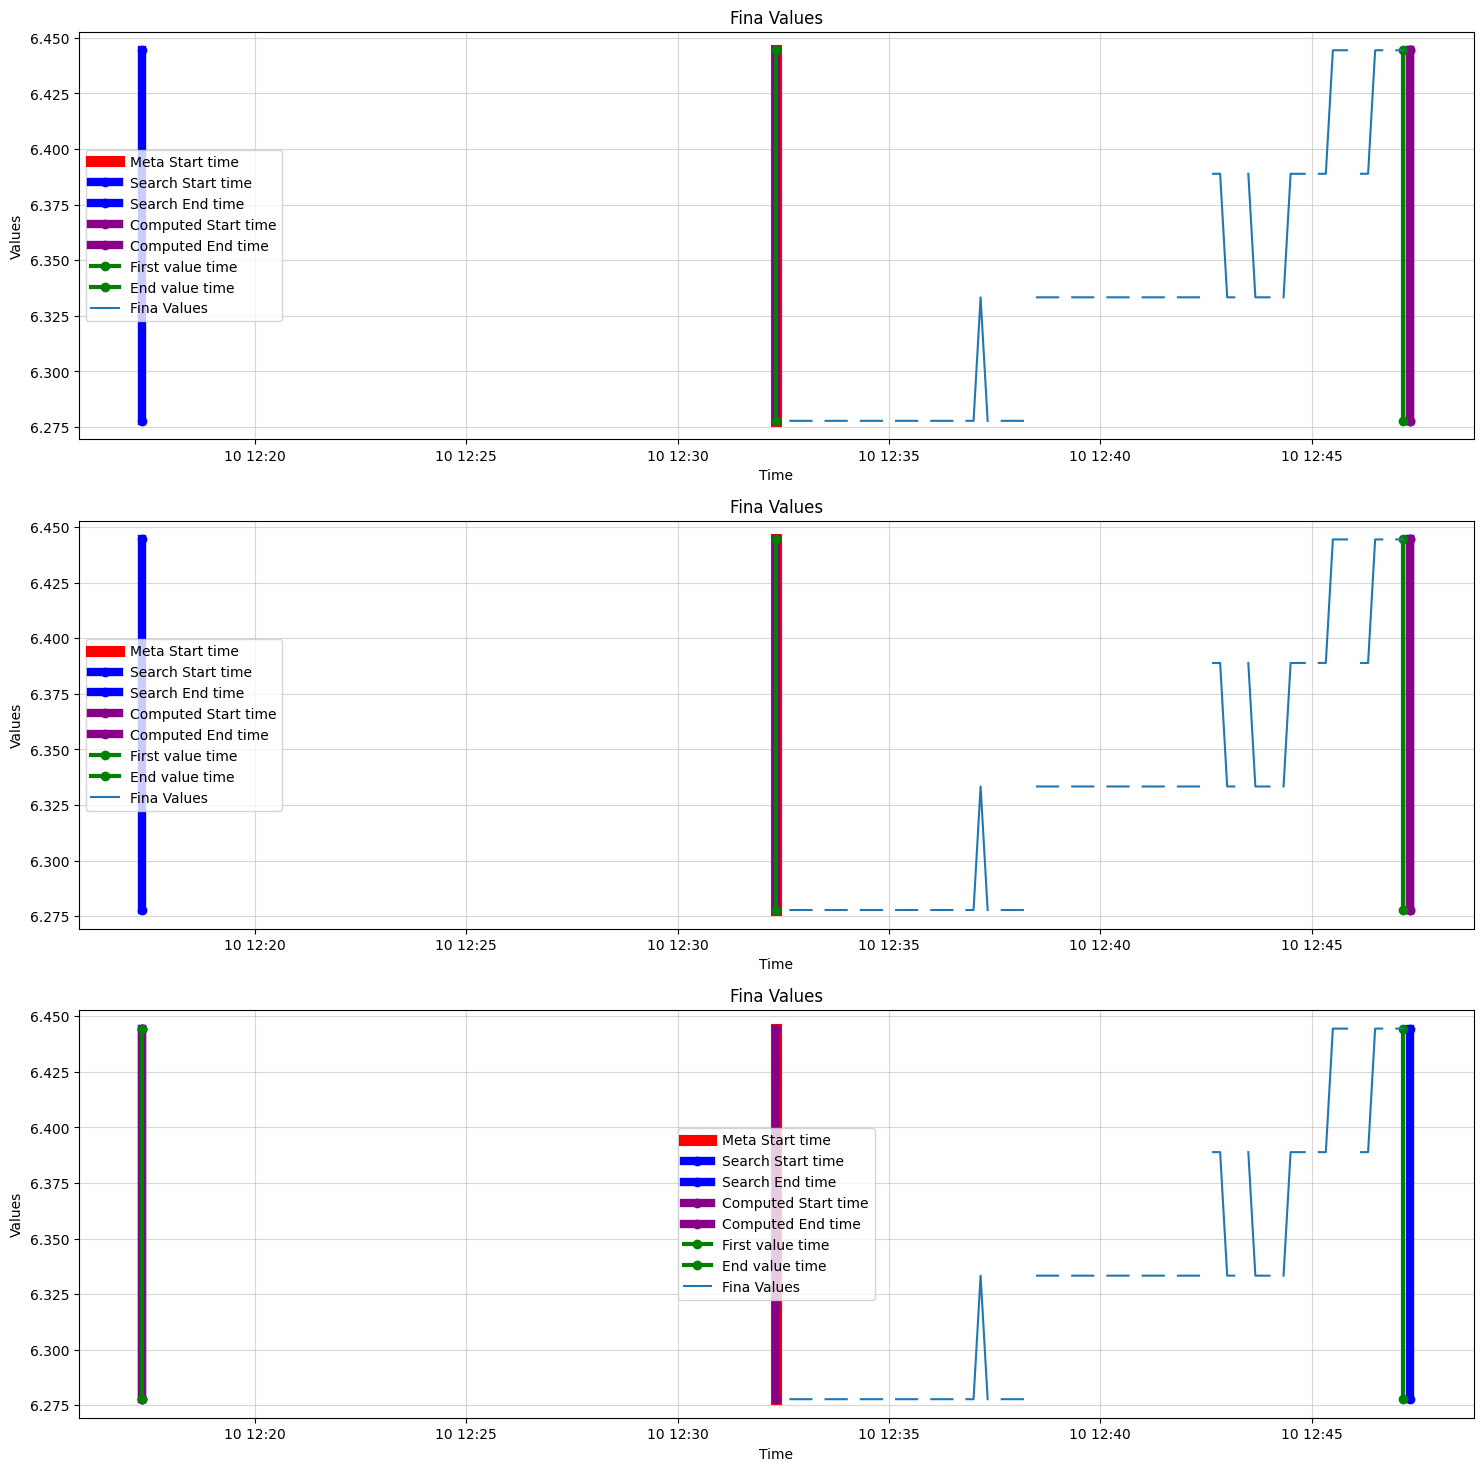

In [3]:
compare_reads(
    time_start=1575981140 - 900,
    time_window=1800,
    time_interval=10,
    output_type=OutputType.TIME_SERIES,
    time_ref_start=TimeRefEnum.BY_TIME
)

#### Case 2: Direct Read BY_SEARCH

---------------
Get data from phpFina File
Feed Id: 1
Data retrieved in 0.006901016982737929s
Meta interval=10 start_time=1575981140 end_time=1621499760 npoints=4551863 size=18207452s
---------------
---------------
Meta: 
Meta Start COMPLETE: 2019-12-10 12:32:20+00:00
Meta Start PARTIAL:  2019-12-10 12:32:20+00:00
Meta Start AS_IS:    2019-12-10 12:32:20+00:00
---------------
Search: 
Search COMPLETE - Start at 2019-12-10 12:29:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:30:00)
Search PARTIAL  - Start at 2019-12-10 12:29:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:30:00)
Search AS_IS    - Start at 2019-12-10 12:29:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:30:00)
Computed Search: 
Computed COMPLETE - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:27:00)
Computed PARTIAL  - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:27:00)
Computed AS_IS    - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 12:

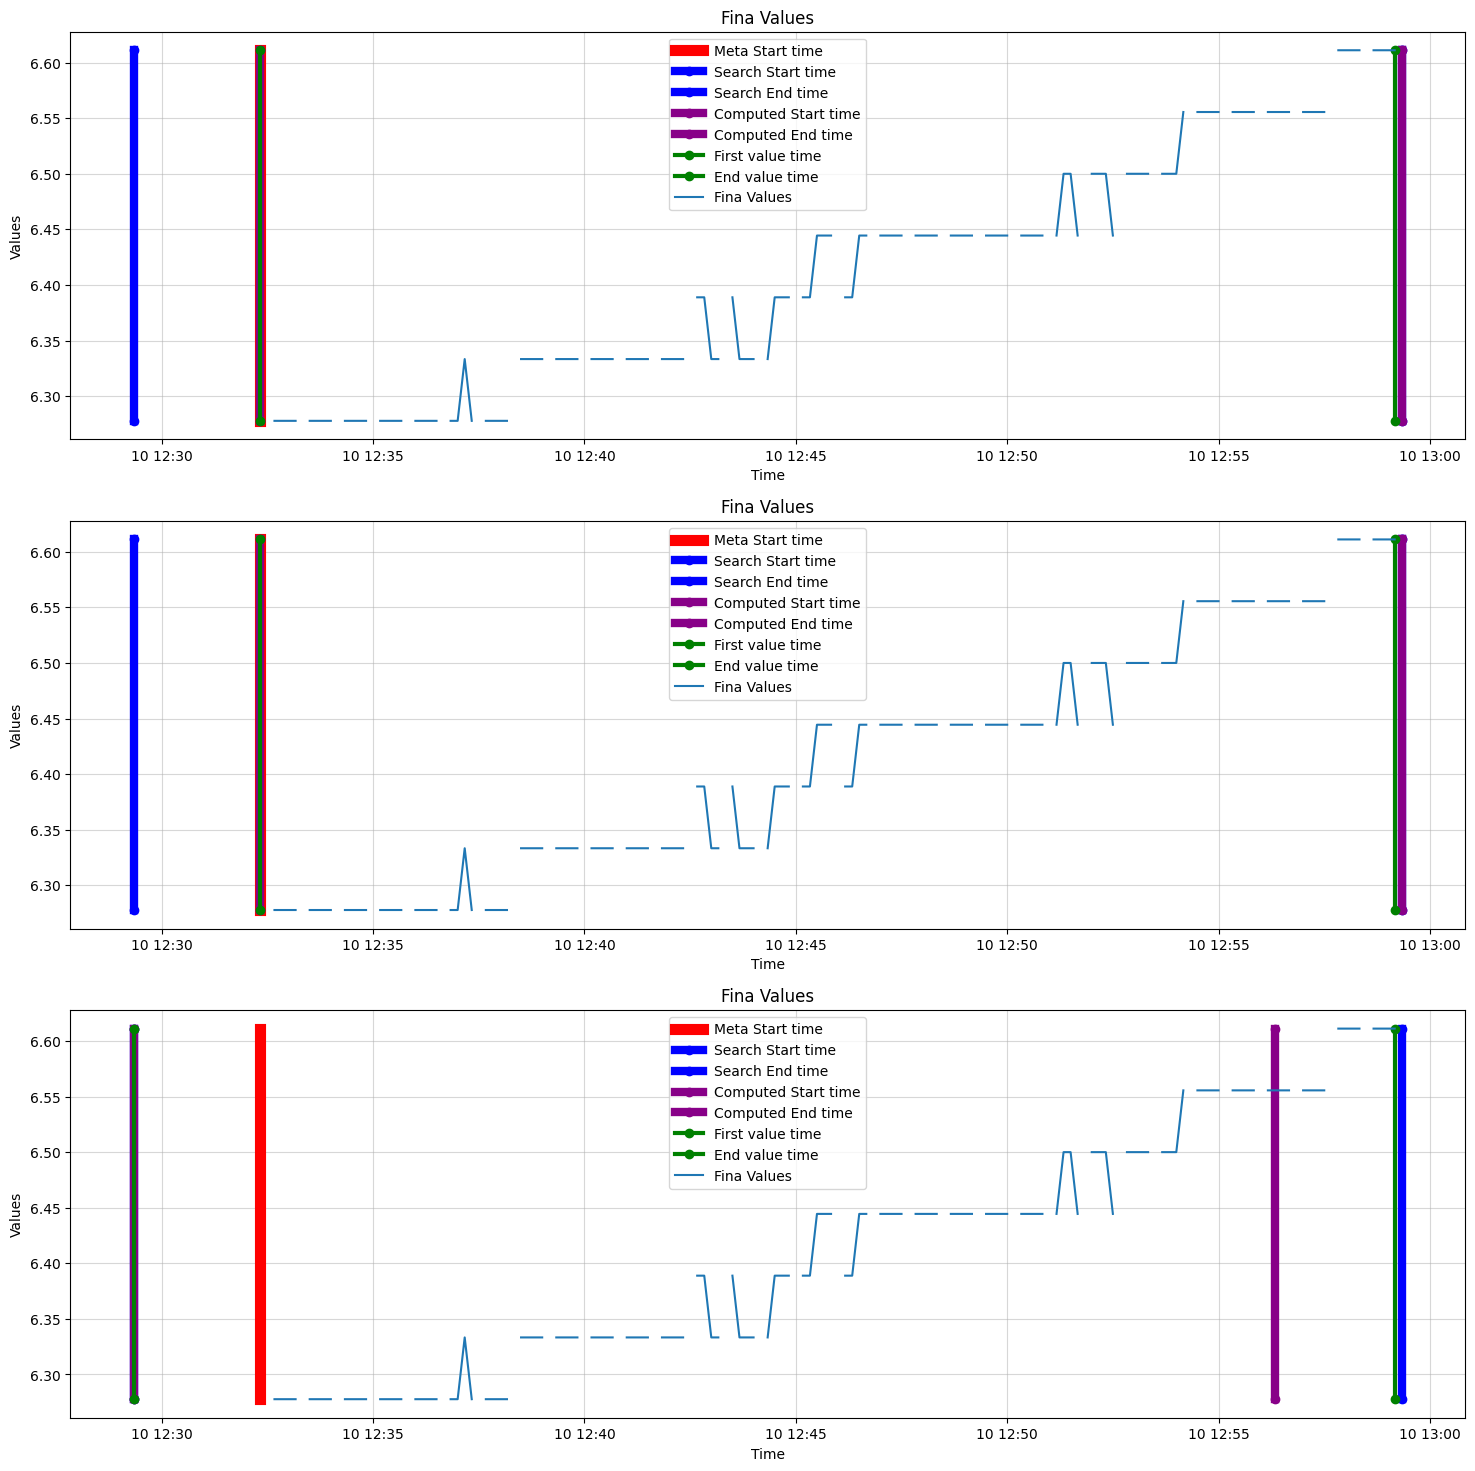

In [4]:
compare_reads(
    time_start=1575981140 - 178,
    time_window=1800,
    time_interval=10,
    output_type=OutputType.TIME_SERIES,
    time_ref_start=TimeRefEnum.BY_SEARCH
)

#### Case 3: Direct Read BY_SEARCH start before

---------------
Get data from phpFina File
Feed Id: 1
Data retrieved in 0.013219624990597367s
Meta interval=10 start_time=1575981140 end_time=1621499760 npoints=4551863 size=18207452s
---------------
---------------
Meta: 
Meta Start COMPLETE: 2019-12-10 12:32:20+00:00
Meta Start PARTIAL:  2019-12-10 12:32:20+00:00
Meta Start AS_IS:    2019-12-10 12:32:20+00:00
---------------
Search: 
Search COMPLETE - Start at 2019-12-10 12:29:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:30:00)
Search PARTIAL  - Start at 2019-12-10 12:29:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:30:00)
Search AS_IS    - Start at 2019-12-10 12:29:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:30:00)
Computed Search: 
Computed COMPLETE - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:27:00)
Computed PARTIAL  - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:27:00)
Computed AS_IS    - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 12:

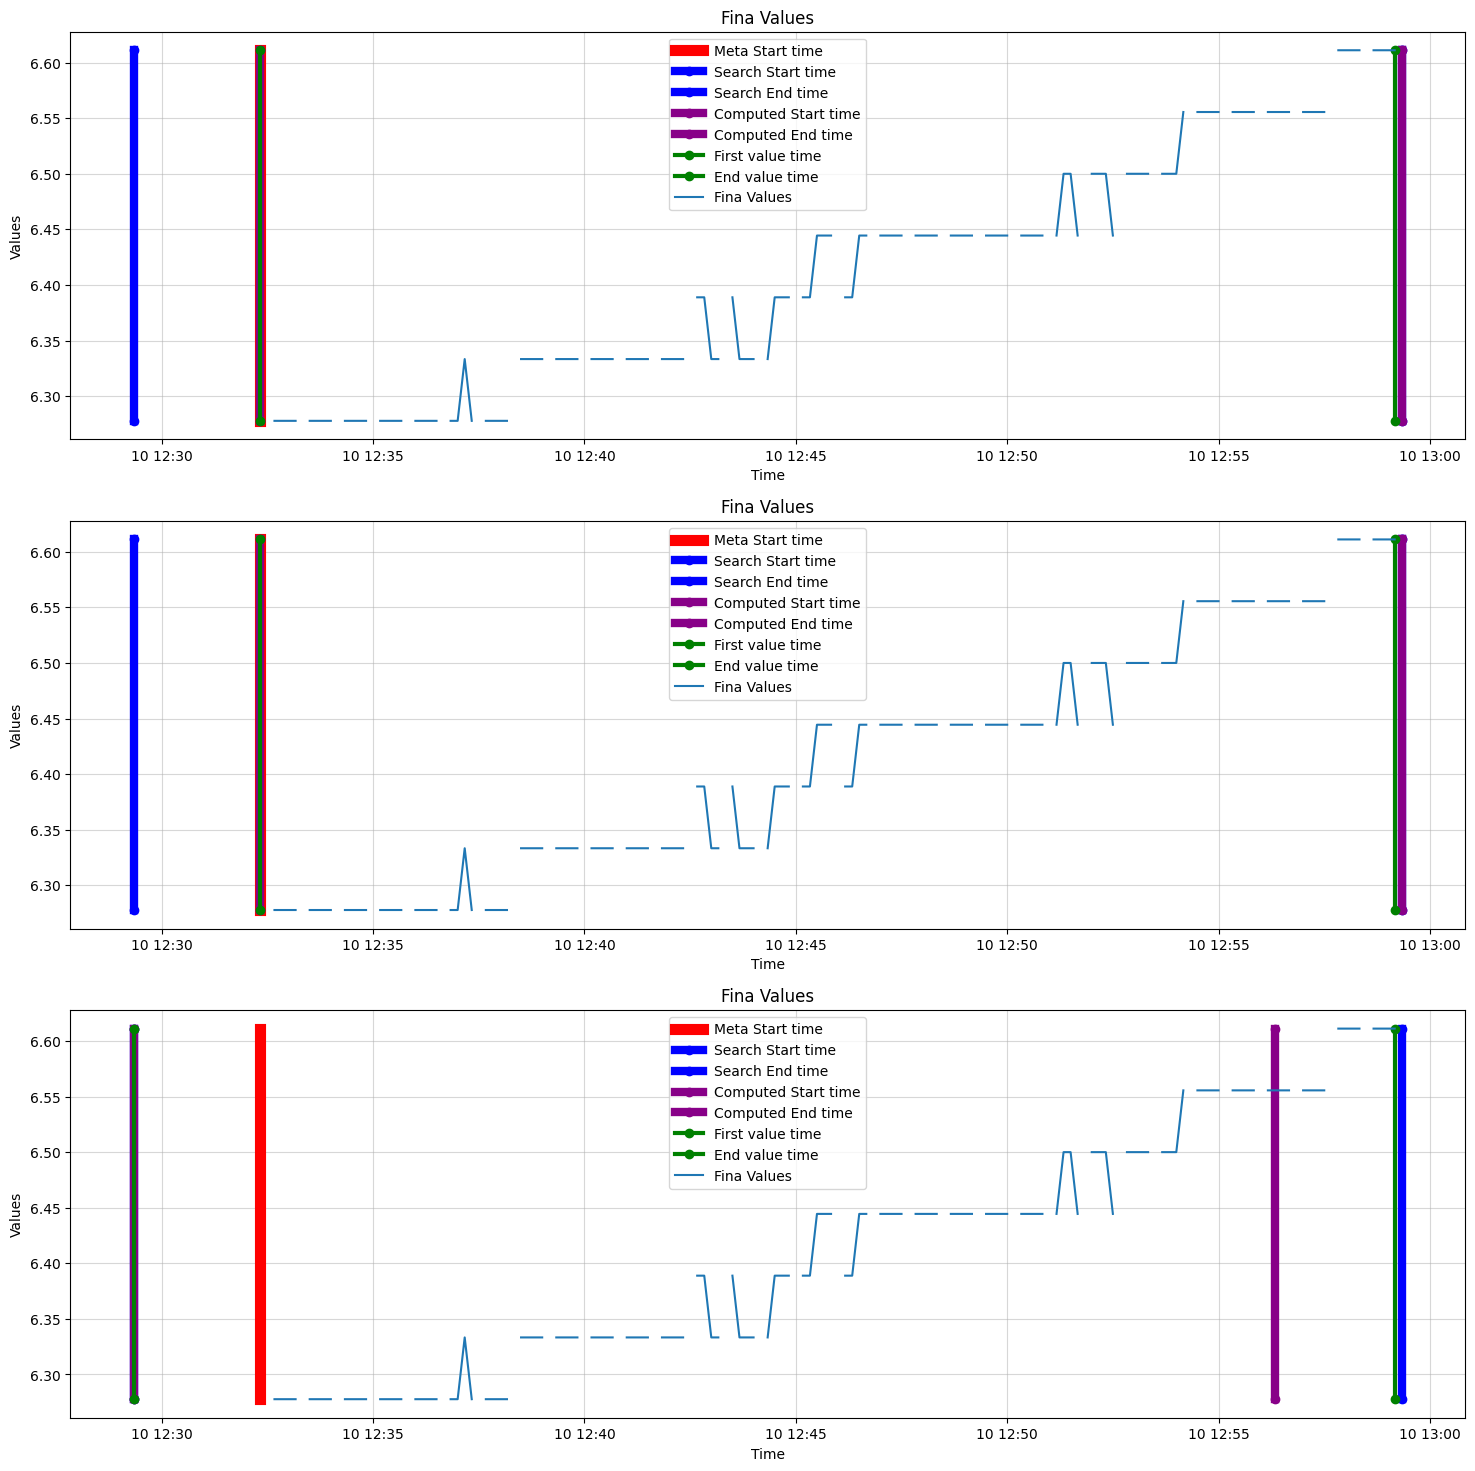

In [5]:
compare_reads(
    time_start=1575981140 - 178,
    time_window=1800,
    time_interval=10,
    output_type=OutputType.TIME_SERIES,
    time_ref_start=TimeRefEnum.BY_SEARCH
)

#### Case 4: Direct Read BY_SEARCH start after

---------------
Get data from phpFina File
Feed Id: 1
Data retrieved in 0.004665336979087442s
Meta interval=10 start_time=1575981140 end_time=1621499760 npoints=4551863 size=18207452s
---------------
---------------
Meta: 
Meta Start COMPLETE: 2019-12-10 12:32:20+00:00
Meta Start PARTIAL:  2019-12-10 12:32:20+00:00
Meta Start AS_IS:    2019-12-10 12:32:20+00:00
---------------
Search: 
Search COMPLETE - Start at 2019-12-10 13:32:20+00:00 -- End at 2019-12-10 14:02:20+00:00 -- (0:30:00)
Search PARTIAL  - Start at 2019-12-10 13:32:20+00:00 -- End at 2019-12-10 14:02:20+00:00 -- (0:30:00)
Search AS_IS    - Start at 2019-12-10 13:32:20+00:00 -- End at 2019-12-10 14:02:20+00:00 -- (0:30:00)
Computed Search: 
Computed COMPLETE - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 13:02:20+00:00 -- (0:30:00)
Computed PARTIAL  - Start at 2019-12-10 13:32:20+00:00 -- End at 2019-12-10 14:02:20+00:00 -- (0:30:00)
Computed AS_IS    - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 14:

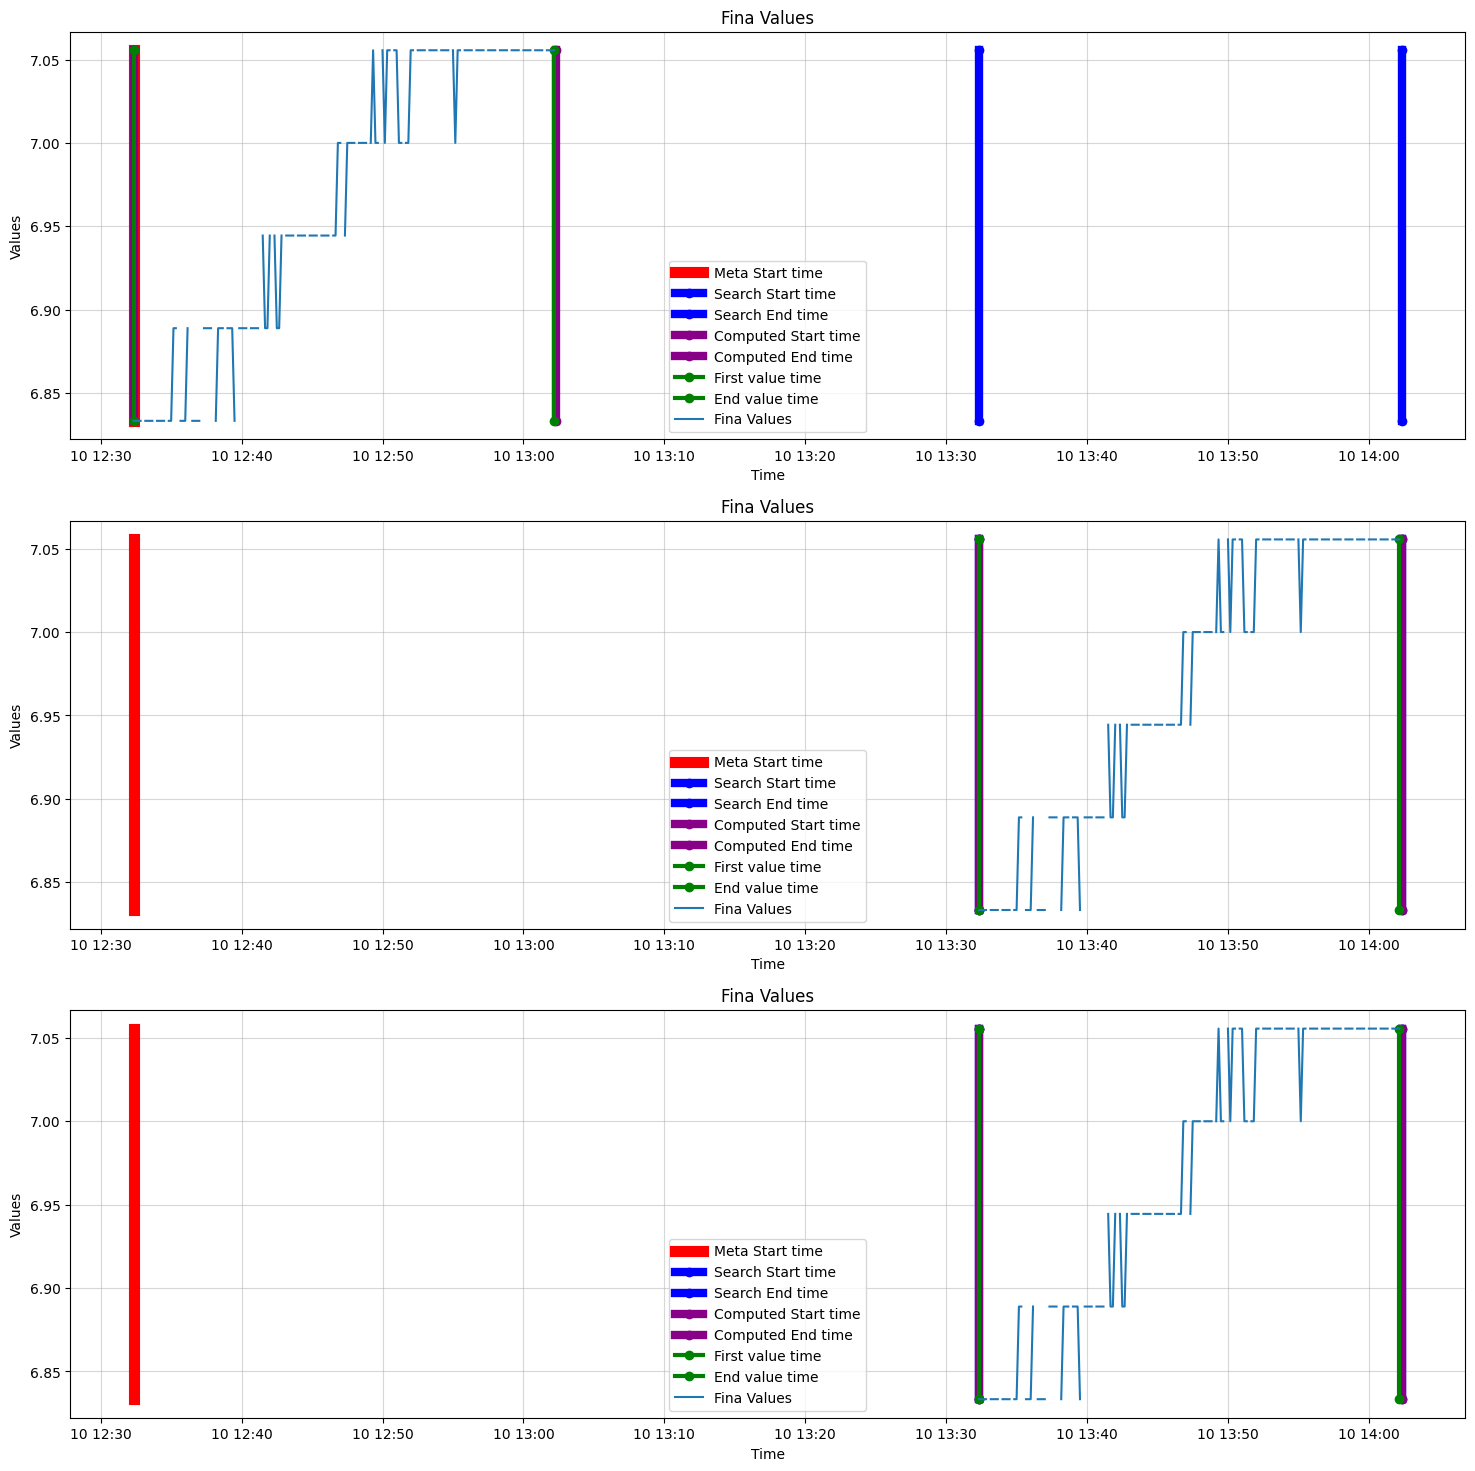

In [7]:
compare_reads(
    time_start=1575981140 + 3600,
    time_window=1800,
    time_interval=10,
    output_type=OutputType.TIME_SERIES,
    time_ref_start=TimeRefEnum.BY_SEARCH
)

#### Case 5: Averaged Reads BY_TIME

---------------
Get data from phpFina File
Feed Id: 1
Data retrieved in 0.009884950006380677s
Meta interval=10 start_time=1575981140 end_time=1621499760 npoints=4551863 size=18207452s
---------------
---------------
Meta: 
Meta Start COMPLETE: 2019-12-10 12:32:20+00:00
Meta Start PARTIAL:  2019-12-10 12:32:20+00:00
Meta Start AS_IS:    2019-12-10 12:32:20+00:00
---------------
Search: 
Search COMPLETE - Start at 2019-12-10 12:29:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:30:00)
Search PARTIAL  - Start at 2019-12-10 12:29:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:30:00)
Search AS_IS    - Start at 2019-12-10 12:29:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:30:00)
Computed Search: 
Computed COMPLETE - Start at 2019-12-10 12:32:00+00:00 -- End at 2019-12-10 12:59:00+00:00 -- (0:27:00)
Computed PARTIAL  - Start at 2019-12-10 12:32:00+00:00 -- End at 2019-12-10 12:59:00+00:00 -- (0:27:00)
Computed AS_IS    - Start at 2019-12-10 12:32:00+00:00 -- End at 2019-12-10 12:

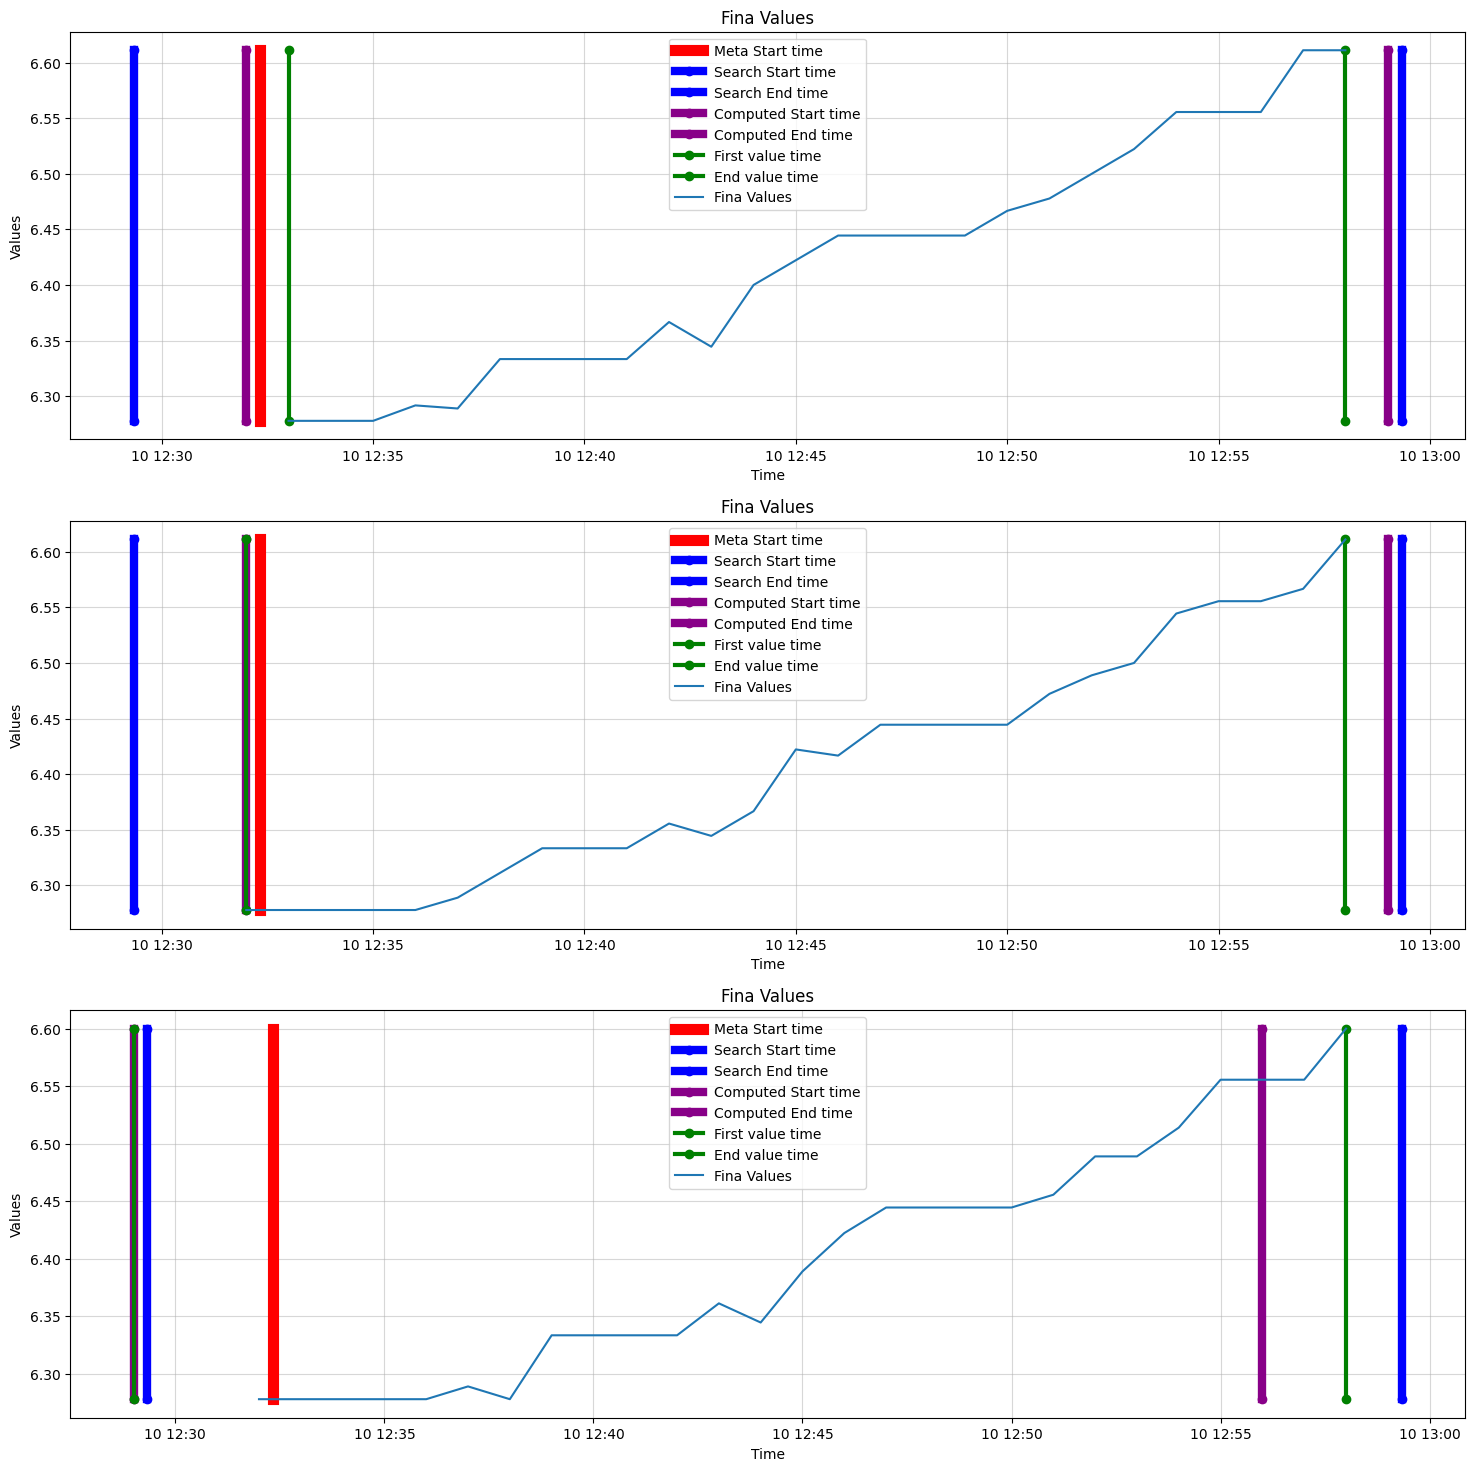

In [ ]:
compare_reads(
    time_start=1575981140 - 178,
    time_window=1800,
    time_interval=60,
    output_type=OutputType.TIME_SERIES,
    time_ref_start=TimeRefEnum.BY_TIME
)

#### Case 6: Averaged Reads BY_SEARCH

---------------
Get data from phpFina File
Feed Id: 1
Data retrieved in 0.01088968594558537s
Meta interval=10 start_time=1575981140 end_time=1621499760 npoints=4551863 size=18207452s
---------------
---------------
Meta: 
Meta Start COMPLETE: 2019-12-10 12:32:20+00:00
Meta Start PARTIAL:  2019-12-10 12:32:20+00:00
Meta Start AS_IS:    2019-12-10 12:32:20+00:00
---------------
Search: 
Search COMPLETE - Start at 2019-12-10 12:29:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:30:00)
Search PARTIAL  - Start at 2019-12-10 12:29:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:30:00)
Search AS_IS    - Start at 2019-12-10 12:29:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:30:00)
Computed Search: 
Computed COMPLETE - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:27:00)
Computed PARTIAL  - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 12:59:20+00:00 -- (0:27:00)
Computed AS_IS    - Start at 2019-12-10 12:32:20+00:00 -- End at 2019-12-10 12:5

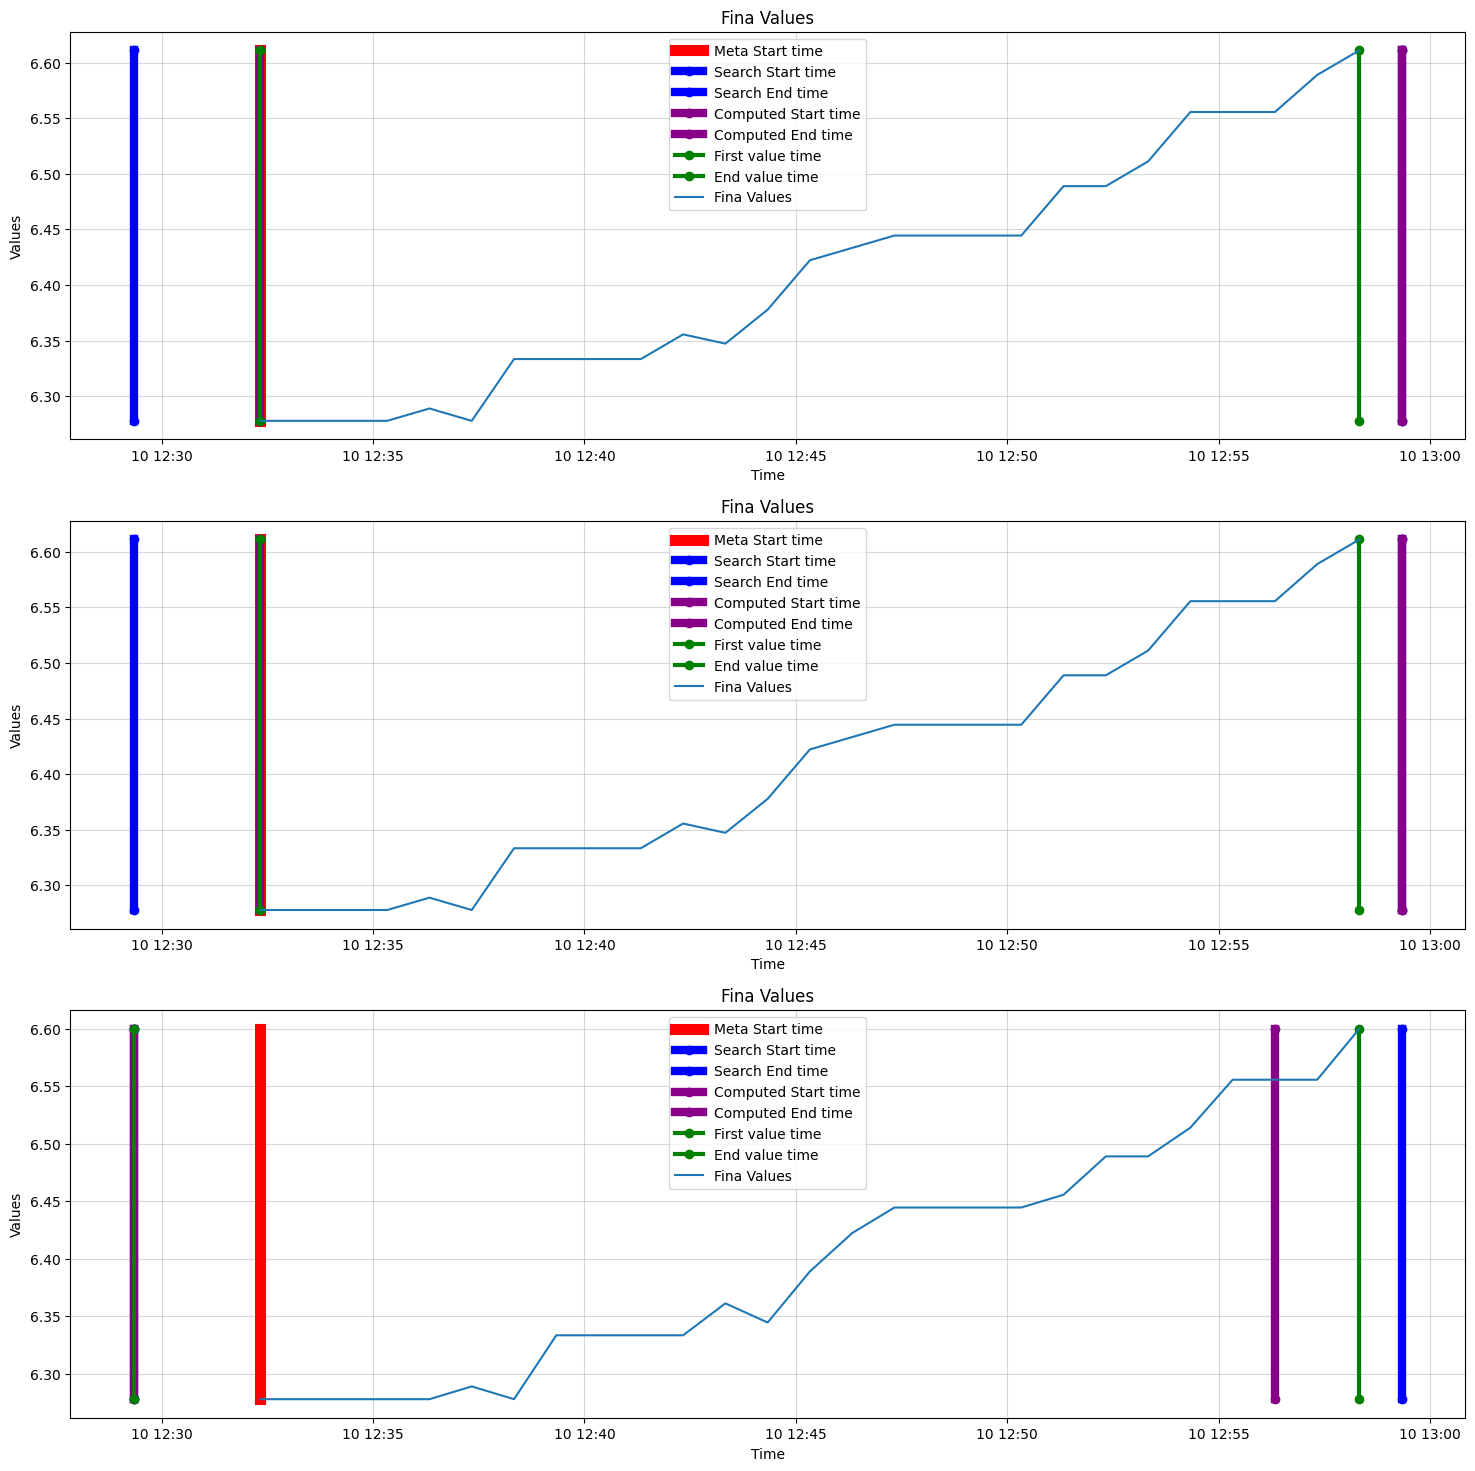

In [ ]:
compare_reads(
    time_start=1575981140 - 178,
    time_window=1800,
    time_interval=60,
    output_type=OutputType.TIME_SERIES,
    time_ref_start=TimeRefEnum.BY_SEARCH
)